In [81]:
# Library import

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

delta=dt.timedelta(days=1)

In [82]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [83]:
fechaIni='2025-01-01'
fechaFin='2025-07-31'
# Consulta a la maestra de recursos
query = f"""
select fechaoperacion, planta, tipo,
hora1, hora2, hora3, hora4, hora5, hora6, hora7, hora8, hora9, hora10, hora11, hora12,
hora13, hora14, hora15, hora16, hora17, hora18, hora19, hora20, hora21, hora22, hora23, hora24
from `enersinc-tbsg-bq`.tbsg.public_ofei
where fechaoperacion >='{fechaIni}' and fechaoperacion <='{fechaFin}' and tipo='D'
and ( planta in ('BARRANQUILLA3 ','BARRANQUILLA4 ','CARTAGENA1 ','CARTAGENA2 ','CARTAGENA3 ','FLORES1GAS ','FLORES1VAPOR ','FLORES2 ','FLORES3 ','FLORES4 ','GUAJIRA1 '
					,'GUAJIRA2 ','PROELECTRICA1 ','PROELECTRICA2 ','TEBSA11 ','TEBSA12 ','TEBSA13 ','TEBSA14 ','TEBSA21 ','TEBSA22 ','TEBSA24 ','TERMOCANDELARIACC1 '
					,'TERMOCANDELARIACC2 ','TERMOCANDELARIACC3 ','TERMOCARIBEIII1 ','TERMONORTE1 ','TERMONORTE10 ','TERMONORTE2 ','TERMONORTE3 ','TERMONORTE4 ','TERMONORTE5 '
					,'TERMONORTE6 ','TERMONORTE7 ','TERMONORTE8 ','TERMONORTE9 ') )
order by fechaoperacion,planta

"""

# Ejecutar la consulta
df_DispUIni = client.query(query).to_dataframe()


In [84]:
# Leer archivo de excel
s_parentpath=Path('C:\Alejo\Eje de Planeación\Análisis Eléctrico\ScriptsPython\ArchivosEntrada')
filepath=s_parentpath.joinpath(s_parentpath,'PesoUnidades.xlsx')

# Loas units
sheet_name='PesoUnidad'
df_Peso=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

In [85]:
df_DispU=df_DispUIni.copy()
df_DispU['flag'] = df_DispU.loc[:, 'hora1':'hora24'].apply(lambda row: 0 if (row == 0).any() else 1, axis=1)
df_DispU = df_DispU[['fechaoperacion','planta','flag']]
df_DispU=df_DispU.merge(df_Peso,left_on=['planta'],right_on=['Unidad'],how='inner')[['fechaoperacion','planta','flag','Peso']]
df_DispU['PesoDia']=df_DispU['flag']*df_DispU['Peso']
df_DispU.head(3)
# df_DispU

,fechaoperacion,planta,flag,Peso,PesoDia
0,2025-01-01,BARRANQUILLA3,1,0.2,0.2
1,2025-01-02,BARRANQUILLA3,1,0.2,0.2
2,2025-01-03,BARRANQUILLA3,1,0.2,0.2


In [86]:
df_DispU_sinTB=df_DispU.copy()
df_DispU_sinTB = df_DispU_sinTB[~df_DispU_sinTB['planta'].isin(['TEBSA11 ', 'TEBSA12 ', 'TEBSA24 '])]

df_DispU_sinTBF=df_DispU.copy()
df_DispU_sinTBF = df_DispU_sinTBF[~df_DispU_sinTBF['planta'].isin(['TEBSA11 ', 'TEBSA12 ', 'TEBSA24 ','FLORES3 '])]

df_DispU_sinTB.head(3)


,fechaoperacion,planta,flag,Peso,PesoDia
0,2025-01-01,BARRANQUILLA3,1,0.2,0.2
1,2025-01-02,BARRANQUILLA3,1,0.2,0.2
2,2025-01-03,BARRANQUILLA3,1,0.2,0.2


In [87]:
df_PesoDiaIni = df_DispU.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)
df_PesoDia_SinTB= df_DispU_sinTB.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)
df_DispU_sinTBF= df_DispU_sinTBF.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)

In [88]:
# Valores de umbral
thresholds = [12,11, 10, 9, 8, 7, 6]

# Calcular probabilidades Inicial
probabilitiesIni = [(df_PesoDiaIni['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Calcular probabilidades Final
probabilities_SinTB = [(df_PesoDia_SinTB['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Calcular probabilidades Final
probabilities_SinTBF = [(df_DispU_sinTBF['PesoDia'] >= threshold).mean() for threshold in thresholds]


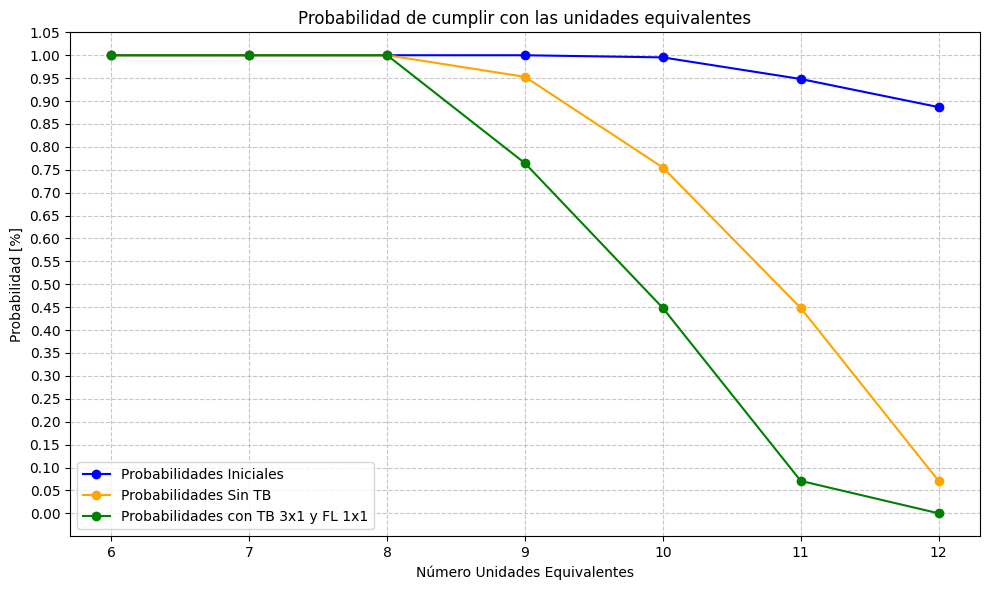

In [89]:
# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.plot(thresholds, probabilitiesIni, marker='o', label='Probabilidades Iniciales', color='blue')
plt.plot(thresholds, probabilities_SinTB, marker='o', label='Probabilidades Sin TB', color='orange')
plt.plot(thresholds, probabilities_SinTBF, marker='o', label='Probabilidades con TB 3x1 y FL 1x1', color='green')

# Configurar el gráfico
plt.title('Probabilidad de cumplir con las unidades equivalentes')
plt.xlabel('Número Unidades Equivalentes')
plt.ylabel('Probabilidad [%]')
plt.xticks(thresholds)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()